In [72]:
# Dependencies
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [73]:
# Load the pose estimation model
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

# Input dimensions and confidence threshold
inWidth = 368
inHeight = 368
thr = 0.2

In [74]:
# Defining the body parts and the pairs on the body parts hat represent connections in a pose estimation model.
BODY_PARTS = { 
    "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
    "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
    "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
    "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 
}

POSE_PAIRS = [ 
    ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
    ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
    ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
    ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
    ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] 
]

In [75]:
# Defining a good pose for the model
good_pose = {
    "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
    "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
    "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13
}

# Show the good pose parameters
print(good_pose)

# Function to check if detected pose contains only required key points
def is_good_pose(detected_pose, good_pose):
    for part, index in good_pose.items():
        if part not in detected_pose or detected_pose[part] is None:
            return False
    return True

# Function to check pose and provide feedback
def check_pose(detected_pose, good_pose):
    if is_good_pose(detected_pose, good_pose):
        return "You look stunning!"
    else:
        return "Please correct your pose."

{'Neck': 1, 'RShoulder': 2, 'RElbow': 3, 'RWrist': 4, 'LShoulder': 5, 'LElbow': 6, 'LWrist': 7, 'RHip': 8, 'RKnee': 9, 'RAnkle': 10, 'LHip': 11, 'LKnee': 12, 'LAnkle': 13}


<function matplotlib.pyplot.show(close=None, block=None)>

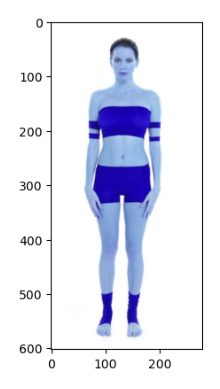

In [76]:
# Loading the image
img = cv.imread("GOTpose20.png")

# Check if image is loaded correctly
if img is None:
    raise FileNotFoundError("The image 'GOTpose20.png' could not be loaded.")

# Create a copy of the image for template matching
img_rgb = img.copy()



# Display the image
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off') # Hide the axis
plt.show

In [77]:
# Define Albumentations transformation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.5),
])

# Apply transformation to the image
augmented = transform(image=img)
img = augmented['image']

In [78]:
# Template matching
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
template = cv.imread('GOTpose20.png', cv.IMREAD_GRAYSCALE)
if template is None:
    raise FileNotFoundError("The image 'GOTpose20.png' could not be loaded.")
w, h = template.shape[::-1]
# Ensure both images are of type CV_8U
if img_gray.dtype != np.uint8:
    img_gray = img_gray.astype(np.uint8)
if template.dtype != np.uint8:
    template = template.astype(np.uint8)

res = cv.matchTemplate(img_gray, template, cv.TM_CCOEFF_NORMED)
threshold = 0.8
loc = np.where(res >= threshold)

for pt in zip(*loc[::-1]):
    cv.rectangle(img, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

In [79]:
# Function to detect the pose
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :] 

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Find the global maximum in the heatmap
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    # Define body parts to keep (head, torso, arms)
    body_parts_to_keep = ["Nose", "Neck", "RShoulder", "RElbow",
                          "LShoulder", "LElbow"]

    box_size = 125  # Half-width and half-height of the box

    # Create a copy of the frame to modify
    output_frame = frame.copy()

    # Set everything initially to white
    output_frame[:, :] = (255, 255, 255)

    for part in body_parts_to_keep:
        part_id = BODY_PARTS[part]

        # Check if the keypoint exists and is valid
        if points[part_id]:
            x, y = points[part_id]

            # Define the rectangular region for the body part
            top_left = (max(0, x - box_size), max(0, y - box_size))
            bottom_right = (min(frameWidth, x + box_size), min(frameHeight, y + box_size))

            # Copy the rectangular region from the original frame to the output frame
            output_frame[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = \
                frame[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

    return output_frame, {part: points[BODY_PARTS[part]] for part in BODY_PARTS}

In [80]:
# Perform pose estimation on the image
estimated_image, detected_pose = pose_estimation(img)

In [81]:
# Get the feedback message
message = check_pose(detected_pose, good_pose)
print(message)

You look stunning!


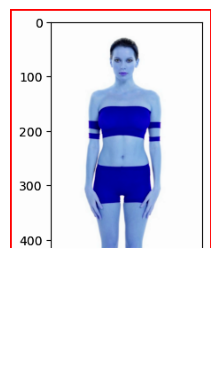

In [82]:
# Display the image with the pose estimation
plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))
plt.axis('off')  # Hide the axis
plt.show()

In [83]:
# Display the estimated image with template matching
cv.imshow('Detected Image', img_rgb)
cv.waitKey(5000)
cv.destroyAllWindows()